In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
#import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis

In [2]:
job_extra = ["--qos=cf_lowprio"] 
#job_extra =['--qos=lr6_lowprio','--constraint=lr6_m192'] 
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=12, walltime='10:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client = Client(cluster) 
cluster.scale_up(20)

In [15]:
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/'

In [3]:
cluster

In [4]:
#Get all the ensemble member labels in a list and also get a list of dates.
directory   = "/global/scratch/users/harsha/LENS/cesm2/tasmax/TREFHTMX/"
directory0  = "/global/scratch/users/harsha/LENS/cesm2/tasmax"
files       = glob.glob(directory+"b.e21.BHIST*.nc")
datelen     = 20
emembers    = [f.replace(directory,"").replace("b.e21.BHIST","").replace("cam.h1.TREFHTMX.","")\
              .replace("f09_g17.LE2-","").replace("cmip6.","").replace("smbb.","") \
              for f in glob.glob(directory+"b.e21.BHIST*.nc")] 

dates       = [f[-datelen:].replace('.nc',"") for f in emembers]
emembers    = [f.replace(f[-datelen:],"") for f in emembers]
emembers    = list(set(emembers)) #remove repetitions
emembers    = sorted(emembers) #sort in ascending order
dates       = list(set(dates)) #remove repetitions
dates       = sorted(dates)

In [5]:
print(dates,emembers)

['18500101-18591231', '18600101-18691231', '18700101-18791231', '18800101-18891231', '18900101-18991231', '19000101-19091231', '19100101-19191231', '19200101-19291231', '19300101-19391231', '19400101-19491231', '19500101-19591231', '19600101-19691231', '19700101-19791231', '19800101-19891231', '19900101-19991231', '20000101-20091231', '20100101-20141231'] ['1001.001.', '1011.001.', '1021.002.', '1031.002.', '1041.003.', '1051.003.', '1061.004.', '1071.004.', '1081.005.', '1091.005.', '1101.006.', '1111.006.', '1121.007.', '1131.007.', '1141.008.', '1151.008.', '1161.009.', '1171.009.', '1181.010.', '1191.010.', '1231.001.', '1231.002.', '1231.003.', '1231.004.', '1231.005.', '1231.006.', '1231.007.', '1231.008.', '1231.009.', '1231.010.', '1231.011.', '1231.012.', '1231.013.', '1231.014.', '1231.015.', '1231.016.', '1231.017.', '1231.018.', '1231.019.', '1231.020.', '1251.001.', '1251.002.', '1251.003.', '1251.004.', '1251.005.', '1251.006.', '1251.007.', '1251.008.', '1251.009.', '125

In [6]:
#Create a file1, with file paths sorted by time for each ensemble member.
cmip0 = 'b.e21.BHISTcmip6.f09_g17.LE2-'
smbb0 = 'b.e21.BHISTsmbb.f09_g17.LE2-'
file1 = []
for i in range(100):
    file = sorted(glob.glob(directory+cmip0+emembers[i]+'*.nc'))
    file1.append(file)
    if len(file1[i])==0:
           file1[i] = glob.glob(directory+smbb0+emembers[i]+'*.nc')
#file1 is now a list of lists.

In [7]:
len(file1[0])

17

In [10]:
# #Create a file1, with file paths sorted by emember for each time period.
# file2 = []
# for j in range(17):
#     file0  = sorted(glob.glob(directory+cmip0+'*'+dates[j]+'.nc'))
#     file1  = sorted(glob.glob(directory+smbb0+'*'+dates[j]+'.nc'))
#     file01 = file0 +file1
#     file2.append(file01)
# #file2 is now a list of lists.

In [9]:
len(file2[0])

100

In [10]:
#Create zarr paths
scratchf  = '/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/'
scratchf1 = '/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/'
filename  = 'b.e21.BHIST.'
path      = scratchf+filename
emembs    = list(range(100))
emembs    = [str(ememb).zfill(3) for ememb in emembs]
paths     = []
paths1    = []
for ii in range(100):
    path00 = scratchf+filename+emembs[ii]+'.zarr'
    paths.append(path00)
for jj in range(17):
    path0  = scratchf1+filename+'tasmax.'+ dates[jj]+'.zarr'
    paths1.append(path0)

In [11]:
paths[16]

'/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.016.zarr'

In [13]:
%%time
#Write zarr files where each zarr file has all time series data for one ensemble.
for jj in range(100):
    ds = xr.open_mfdataset(file1[jj],decode_times=True,decode_timedelta='True')
    ds = ds.TREFHTMX
    ds = ds.expand_dims(dim='member',axis=3).assign_coords(member=('member',[jj]))
    #print(ds)
    ds = ds.to_dataset()
    print(paths[jj])
    ds.to_zarr(paths[jj],mode='w')
    #print('Wrote zarr file.')
    ds.close()
    print('Closed directory')

/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.000.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.001.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.002.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.003.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.004.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.005.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.009.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.010.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.011.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.012.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tma

Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.090.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.091.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.092.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.093.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.094.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.095.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.096.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.097.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.098.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/tmax_emem/b.e21.BHIST.099.zarr
Closed directory
CPU times: user 12min 20s, sys: 2

In [13]:
%%time
#file2
dst = xr.open_mfdataset(file2[0],decode_times=True,decode_timedelta='True',combine='nested',concat_dim='member')

CPU times: user 1min 19s, sys: 4.12 s, total: 1min 23s
Wall time: 7min 22s


In [14]:
%%time
ds_temp = xr.open_mfdataset(paths,engine='zarr')

CPU times: user 49.6 s, sys: 1.21 s, total: 50.8 s
Wall time: 50.4 s


In [16]:
ds_temp

,Array,Chunk
Bytes,1.21 TiB,769.92 MiB
Shape,"(60226, 192, 288, 100)","(3650, 192, 288, 1)"
Count,3500 Tasks,1700 Chunks
Type,float32,numpy.ndarray


In [17]:
%%time
ds_temp.to_zarr(cesm2_path+'tasmax/bhist_cesm2tmax.zarr')

CPU times: user 44 s, sys: 1.34 s, total: 45.3 s
Wall time: 2min 32s


In [19]:
%%time
ds_temp1 = xr.open_mfdataset(cesm2_path+'tasmax/bhist_cesm2tmax.zarr',engine='zarr')
ds_temp1

CPU times: user 384 ms, sys: 21.4 ms, total: 405 ms
Wall time: 415 ms


,Array,Chunk
Bytes,1.21 TiB,769.92 MiB
Shape,"(60226, 192, 288, 100)","(3650, 192, 288, 1)"
Count,1701 Tasks,1700 Chunks
Type,float32,numpy.ndarray


In [52]:
# %%time
# #Write zarr files where each zarr has data for a 10-year period and all ensembles
# for kk in range(17):
#     ds = xr.open_mfdataset(file2[kk],decode_times=True,decode_timedelta='True',combine='nested',concat_dim='member')
#     ds = ds.TREFHTMX
#     ds = ds.assign_coords(member=('member',np.arange(100)))
#     #print(ds)
#     ds = ds.to_dataset()
#     print(paths1[kk])
#     ds.to_zarr(paths1[kk],mode='w')
#     #print('Wrote zarr file.')
#     ds.close()
#     print('Closed directory')

/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.18500101-18591231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.18600101-18691231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.18700101-18791231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.18800101-18891231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.18900101-18991231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.19000101-19091231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.19100101-19191231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.19200101-19291231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/c

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.19900101-19991231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.20000101-20091231.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/tasmax/cby_ensemble/b.e21.BHIST.tasmax.20100101-20141231.zarr
Closed directory
CPU times: user 8min 18s, sys: 25.5 s, total: 8min 44s
Wall time: 29min 42s


In [29]:
len(paths1)

17

In [63]:
%%time
ds_chk = xr.open_mfdataset(paths[:],engine='zarr')
ds_chk

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/backends/api.py:908: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datasets = [open_(p, **open_kwargs) for p in paths]


,Array,Chunk
Bytes,1.20 TiB,769.92 MiB
Shape,"(60226, 192, 288, 99)","(3650, 192, 288, 1)"
Count,3465 Tasks,1683 Chunks
Type,float32,numpy.ndarray


In [13]:
%%time
ds_check = xr.open_mfdataset(paths1[:],engine='zarr')
ds_check = ds_check.TREFHTMX
ds_check

CPU times: user 1.19 s, sys: 113 ms, total: 1.3 s
Wall time: 2.57 s


,Array,Chunk
Bytes,1.21 TiB,769.92 MiB
Shape,"(100, 60226, 192, 288)","(1, 3650, 192, 288)"
Count,3417 Tasks,1700 Chunks
Type,float32,numpy.ndarray


In [16]:
ds_check = ds_check.chunk(chunks={'member':100,'time':50})
#ds_check
ds_check.to_dataset()

,Array,Chunk
Bytes,1.21 TiB,1.03 GiB
Shape,"(100, 60226, 192, 288)","(100, 50, 192, 288)"
Count,41814 Tasks,1205 Chunks
Type,float32,numpy.ndarray


In [36]:
%%time
ds_cmean = ds_check.mean('member')
ds_cmean = ds_cmean.chunk(chunks={'time':3650})
ds_cmean =ds_cmean.to_dataset()
ds_cmean

CPU times: user 66.7 ms, sys: 3.97 ms, total: 70.7 ms
Wall time: 68.9 ms


<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 60226)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time      (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Data variables:
    TREFHTMX  (time, lat, lon) float32 dask.array<chunksize=(3650, 192, 288), meta=np.ndarray>

In [27]:
%%time
ds_cmean.compute()

CPU times: user 59.1 s, sys: 3.92 s, total: 1min 2s
Wall time: 4min 57s


<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 3650)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time      (time) object 1850-01-01 00:00:00 ... 1859-12-31 00:00:00
Data variables:
    TREFHTMX  (time, lat, lon) float32 245.4 245.4 245.4 ... 245.4 245.4 245.4

In [35]:
dates0 = [ii[:8] for ii in dates]
dates0
dates1 = [jj[9:] for jj in dates]
dates1

['18591231',
 '18691231',
 '18791231',
 '18891231',
 '18991231',
 '19091231',
 '19191231',
 '19291231',
 '19391231',
 '19491231',
 '19591231',
 '19691231',
 '19791231',
 '19891231',
 '19991231',
 '20091231',
 '20141231']

In [37]:
%%time
cvals      = '/global/scratch/users/harsha/LENS/cesm2'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/cby_ensemble'
filename   = 'b.e21.BHIST.'
var0       = 'TREFHTMX.ensmean.'
mpaths     = []
for i in range(17):
    mpath  =  cvals+'/means/'+ var0+dates[i]+'.zarr'
    mpaths.append(mpath)
#mpaths
for j in range(17):
    ds = ds_cmean.sel(time=slice(dates0[j],dates1[j]))
    ds.to_zarr(mpaths[j],mode='w')
    ds.close()
    print('Wrote file #',j)

Wrote file # 0
Wrote file # 1
Wrote file # 2
Wrote file # 3
Wrote file # 4
Wrote file # 5
Wrote file # 6
Wrote file # 7
Wrote file # 8
Wrote file # 9
Wrote file # 10
Wrote file # 11
Wrote file # 12
Wrote file # 13
Wrote file # 14
Wrote file # 15
Wrote file # 16
CPU times: user 16min 56s, sys: 45.3 s, total: 17min 41s
Wall time: 1h 18min 59s


In [41]:
%%time
ds_mcheck = xr.open_mfdataset(mpaths,engine='zarr')
ds_mcheck

CPU times: user 772 ms, sys: 64.6 ms, total: 837 ms
Wall time: 839 ms


<xarray.Dataset>
Dimensions:   (time: 60225, lat: 192, lon: 288)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time      (time) object 1850-01-01 00:00:00 ... 2014-12-31 00:00:00
Data variables:
    TREFHTMX  (time, lat, lon) float32 dask.array<chunksize=(3650, 192, 288), meta=np.ndarray>

In [44]:
%%time
#Write standard deviations
ds_cstd    = ds_check.std('member')
ds_cstd    = ds_cstd.chunk(chunks={'time':3650})
ds_cstd    = ds_cstd.to_dataset()
spaths     = []
for i in range(17):
    spath  =  cvals+'/stds/'+ var0+dates[i]+'.zarr'
    spaths.append(spath)
#mpaths
for j in range(17):
    ds = ds_cstd.sel(time=slice(dates0[j],dates1[j]))
    ds.to_zarr(spaths[j],mode='w')
    ds.close()
    print('Wrote file #',j)


Wrote file # 0
Wrote file # 1
Wrote file # 2
Wrote file # 4
Wrote file # 5
Wrote file # 6
Wrote file # 7
Wrote file # 8
Wrote file # 9
Wrote file # 10
Wrote file # 11
Wrote file # 12
Wrote file # 13
Wrote file # 14
Wrote file # 15
Wrote file # 16
CPU times: user 16min 43s, sys: 43.8 s, total: 17min 27s
Wall time: 1h 20min 42s


In [56]:
ds_cstd.nbytes//1e9

13.0

In [57]:
ds_cmean_check.nbytes//1e9

13.0

In [58]:
%%time
ttemp0 = ds_cmean_check.TREFHTMX.sel(lat=37.8715,lon=238.27,method='nearest').sel(time=slice("1850-01-01", "1920-12-31"))

NameError: name 'ds_cmean_check' is not defined

In [106]:
ttemp0.time[0]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    lat      float64 38.17
    lon      float64 238.8
    time     object 1850-01-01 00:00:00
Attributes:
    bounds:     time_bnds
    long_name:  time

In [95]:
ttemp0 = ttemp0.grouby(time.dayofyear)

AttributeError: 'DataArray' object has no attribute 'grouby'

In [ ]:
ttemp1 = ds_cmean_check.sel(lat=37.8715,lon=238.27,method='nearest').sel(time=slice("1850-01-01", "1920-12-31"))

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


CPU times: user 5.61 s, sys: 370 ms, total: 5.97 s
Wall time: 10.7 s


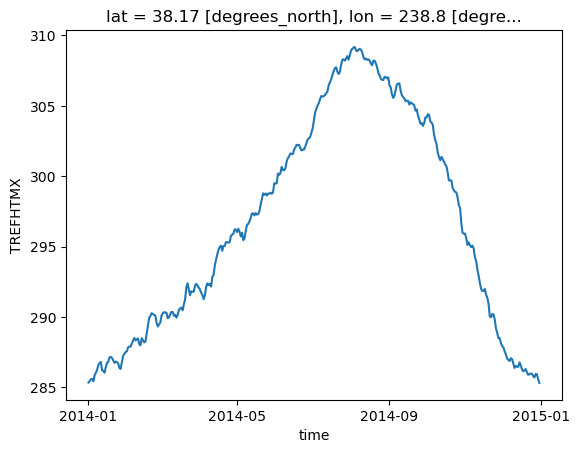

In [85]:
%%time
test0 = ds_cmean_check.TREFHTMX.sel(lat=37.8715,lon=238.27,method='nearest').sel(time=slice("2014-01-01", "2014-12-31"))
test0.plot()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


CPU times: user 13.3 s, sys: 593 ms, total: 13.9 s
Wall time: 1min 44s


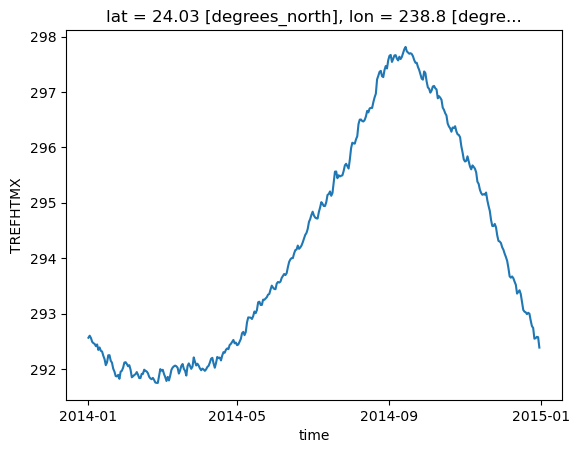

In [49]:
%%time
ds_cmean_check.TREFHTMX.sel(lat=23.8715,lon=238.27,method='nearest').sel(time=slice("2014-01-01", "2014-12-31")).plot()

In [22]:
result.nbytes/1e9

0.80735464

In [31]:
mean1.indexes['time'].to_datetimeindex()

/tmp/ipykernel_40260/3078645660.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  mean1.indexes['time'].to_datetimeindex()


DatetimeIndex(['1850-01-01', '1850-01-02', '1850-01-03', '1850-01-04',
               '1850-01-05', '1850-01-06', '1850-01-07', '1850-01-08',
               '1850-01-09', '1850-01-10',
               ...
               '1859-12-22', '1859-12-23', '1859-12-24', '1859-12-25',
               '1859-12-26', '1859-12-27', '1859-12-28', '1859-12-29',
               '1859-12-30', '1859-12-31'],
              dtype='datetime64[ns]', length=3650, freq=None)